## Testing hypothesis 2
---

**_Hypothesis_**: Reviews with more positive sentiment words receive higher helpfulness ratings.

- **Metric**: Mean helpfulness ratings for number of positive and negative words.

- **Model**: Multinomial Naive Bayes.

- **Description**:

  - Use NBC as a classifier to predict the sentiment of a review.
  - Extract the most useful words from the classifier.
  - Compute the mean helpfulness ratings for the most useful words.

**Missing Values**:

  - `review/score`: remove the entire sample
  - `review/text`: remove the entire sample
  - `review/helpfulness`: remove the entire sample

**Data Transformation**:

  - `review/score`: Assign 1 to score (4, 5), 0 to score (1, 2).
  - `review/text`: Create the BoW for the text. Fit a MNBC and count the number of positive and negative words. Graphical Plot.
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$

---

In [1]:
# Import libraries
import nltk
import findspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from nltk.corpus import stopwords
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import udf

nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/davide/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Initialize spark
findspark.init()
spark = SparkSession.builder.master(
    'local[*]').config("spark.driver.memory", "4g").appName("hypothesis_2").getOrCreate()

ratings_schema = StructType([
    StructField("Title", StringType(), True),
    StructField("Price", FloatType(), True),
    StructField("User_id", IntegerType(), True),
    StructField("profileName", StringType(), True),
    StructField("review/score", FloatType(), True),
    StructField("review/time", IntegerType(), True),
    StructField("review/summary", StringType(), True),
    StructField("review/text", StringType(), True),
    StructField("N_helpful", IntegerType(), True),
    StructField("Tot_votes", IntegerType(), True)
])

df_ratings = spark.read.csv('hdfs://localhost:9900/user/book_reviews/books_rating_cleaned.csv',
                            header=True, schema=ratings_schema, sep='\t')
df_ratings.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/23 10:39:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+-----+-------+--------------------+------------+-----------+--------------------+--------------------+---------+---------+
|               Title|Price|User_id|         profileName|review/score|review/time|      review/summary|         review/text|N_helpful|Tot_votes|
+--------------------+-----+-------+--------------------+------------+-----------+--------------------+--------------------+---------+---------+
|Its Only Art If I...| null|   null|Jim of Oz  jim-of-oz|         4.0|  940636800|Nice collection o...|This is only for ...|        7|        7|
|Dr. Seuss: Americ...| null|   null|       Kevin Killian|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|       10|       10|
|Dr. Seuss: Americ...| null|   null|        John Granger|         5.0| 1078790400|Essential for eve...|If people become ...|       10|       11|
|Dr. Seuss: Americ...| null|   null|Roy E. Perry  ama...|         4.0| 1090713600|Phlip Nel gives s...|Theodore Seuss Ge...|      

### Data preparation for the training of NB model

In [3]:
# Filter the data
df_ratings_filtered = df_ratings.filter(df_ratings['review/text'].isNotNull())

df_ratings_filtered = df_ratings_filtered.filter(
    df_ratings_filtered['review/score'] != 3)

df_ratings_filtered = df_ratings_filtered.filter(
    df_ratings_filtered['Tot_votes'] != 0)

# Remove punctuation and convert to lowercase the review/text column
df_ratings_filtered = df_ratings_filtered.withColumn('review/text', lower(regexp_replace(
    df_ratings_filtered['review/text'], r'[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]', ' ')))

# remove words with length less than 2
df_ratings_filtered = df_ratings_filtered.withColumn(
    'review/text', regexp_replace('review/text', r'\b\w{1,2}\b', ' '))

# Add the helpfulness ratio column
df_ratings_filtered = df_ratings_filtered.withColumn(
    'helpfulness_ratio', df_ratings_filtered['N_helpful']/df_ratings_filtered['Tot_votes']
    *sqrt(df_ratings_filtered['Tot_votes']))

# Add the class column
df_ratings_filtered = df_ratings_filtered.withColumn(
    'class', when(df_ratings_filtered['review/score'] >= 4, 1).otherwise(0))

# Retain only the required columns
df_ratings_selected = df_ratings_filtered.select(
    'review/text', 'helpfulness_ratio', 'class')

# Select useful columns and handle missing values
df = df_ratings_selected.select(
    "class", "helpfulness_ratio", "review/text").na.drop()
df.show(5)

+-----+------------------+--------------------+
|class| helpfulness_ratio|         review/text|
+-----+------------------+--------------------+
|    1|2.6457513110645907|this   only for j...|
|    1|3.1622776601683795|  don   care much...|
|    1| 3.015113445777636|  people become t...|
|    1|2.6457513110645907|theodore seuss ge...|
|    1|1.7320508075688772|philip nel      s...|
+-----+------------------+--------------------+
only showing top 5 rows



### Training of a multinomial Naive Bayes

In [4]:
tokenizer = Tokenizer(inputCol="review/text", outputCol="words")
stop_words_remover = StopWordsRemover(
    inputCol="words", outputCol="filtered_words")

# Convert words to a BoW feature vector
vectorizer = CountVectorizer(
    inputCol="filtered_words", outputCol="features", vocabSize=2000)

nb = NaiveBayes(labelCol="class", featuresCol="features",
                predictionCol="prediction")

pipeline = Pipeline(stages=[tokenizer, stop_words_remover, vectorizer, nb])
model = pipeline.fit(df)

nb_model = model.stages[-1]

### Get most positive words

In [5]:
vocabulary = model.stages[2].vocabulary

# Calculate the difference in word probabilities between class 1 and class 0
class_0_probs = nb_model.theta.toArray()[0]
class_1_probs = nb_model.theta.toArray()[1]
pos_neg_ratio = class_1_probs - class_0_probs

schema = StructType([
    StructField("word", StringType(), True),
    StructField("pos_neg_ratio", FloatType(), True)
])

data = [(word, float(ratio)) for word, ratio in zip(vocabulary, pos_neg_ratio)]
results_df = spark.createDataFrame(data, schema=schema)

sorted_results_df = results_df.orderBy(col("pos_neg_ratio").desc())
top_positive_words_df = sorted_results_df.limit(800)
top_positive_words_df.show()

+-----------+-------------+
|       word|pos_neg_ratio|
+-----------+-------------+
|   captures|    1.8996725|
|      bilbo|    1.8263352|
| delightful|    1.7812135|
|   timeless|    1.7239392|
| refreshing|    1.7135963|
|wonderfully|    1.5773607|
|beautifully|    1.5569794|
|    delight|    1.5262294|
|      darcy|    1.4731687|
| remarkable|    1.4675719|
| accessible|    1.3800385|
|outstanding|    1.3150533|
|     lennie|    1.3101848|
|     hobbit|    1.3014398|
|   treasure|     1.296238|
| challenges|    1.2852602|
|   terrific|    1.2727247|
|     superb|    1.2699136|
|      helps|    1.2679352|
|    awesome|    1.2618526|
+-----------+-------------+
only showing top 20 rows



### Count the currency of the 800 most positive words in each review

In [6]:
# Tokenize the review/text column into words
words_df = df.withColumn("words", split(col("review/text"), "\\s+"))
words_df.show(5)

top_positive_words_list = top_positive_words_df.select(
    "word").rdd.flatMap(lambda x: x).collect()


def count_words(words):
    return len([word for word in words if word in top_positive_words_list])


count_words_udf = udf(count_words, IntegerType())
words_df = words_df.withColumn("count", count_words_udf(col("words")))
words_df.show(5)

+-----+------------------+--------------------+--------------------+
|class| helpfulness_ratio|         review/text|               words|
+-----+------------------+--------------------+--------------------+
|    1|2.6457513110645907|this   only for j...|[this, only, for,...|
|    1|3.1622776601683795|  don   care much...|[, don, care, muc...|
|    1| 3.015113445777636|  people become t...|[, people, become...|
|    1|2.6457513110645907|theodore seuss ge...|[theodore, seuss,...|
|    1|1.7320508075688772|philip nel      s...|[philip, nel, seu...|
+-----+------------------+--------------------+--------------------+
only showing top 5 rows

+-----+------------------+--------------------+--------------------+-----+
|class| helpfulness_ratio|         review/text|               words|count|
+-----+------------------+--------------------+--------------------+-----+
|    1|2.6457513110645907|this   only for j...|[this, only, for,...|    3|
|    1|3.1622776601683795|  don   care much...|[, don,

### Compute Spearman correlation coefficient

In [7]:
vector_col = VectorAssembler(
    inputCols=['count', 'helpfulness_ratio'], outputCol='features')

dataset = vector_col.transform(words_df).select('features')

corr = Correlation.corr(dataset, 'features', method='spearman').collect()[
    0][0].toArray()[0][1]

print(f'The Spearman correlation coefficient is {corr}')

23/09/23 11:00:10 WARN Executor: Managed memory leak detected; size = 15736822 bytes, task 0.0 in stage 19.0 (TID 189)
23/09/23 11:00:13 WARN Executor: Managed memory leak detected; size = 15736822 bytes, task 0.0 in stage 26.0 (TID 215)


The Spearman correlation coefficient is 0.31873115540472974


### Plot graphs, just to see the distribution of the features

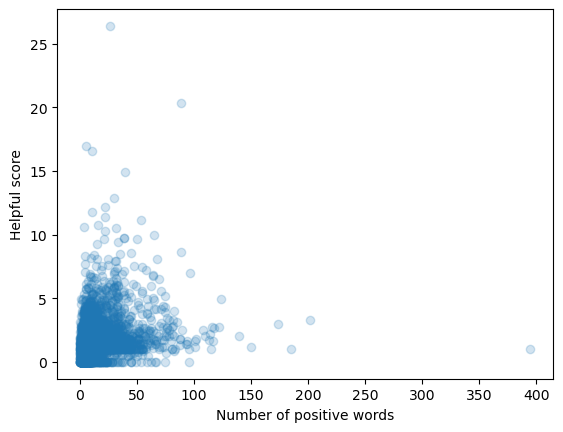

Text(0.5, 1.0, 'Review Length Range vs Helpfulness Rate')

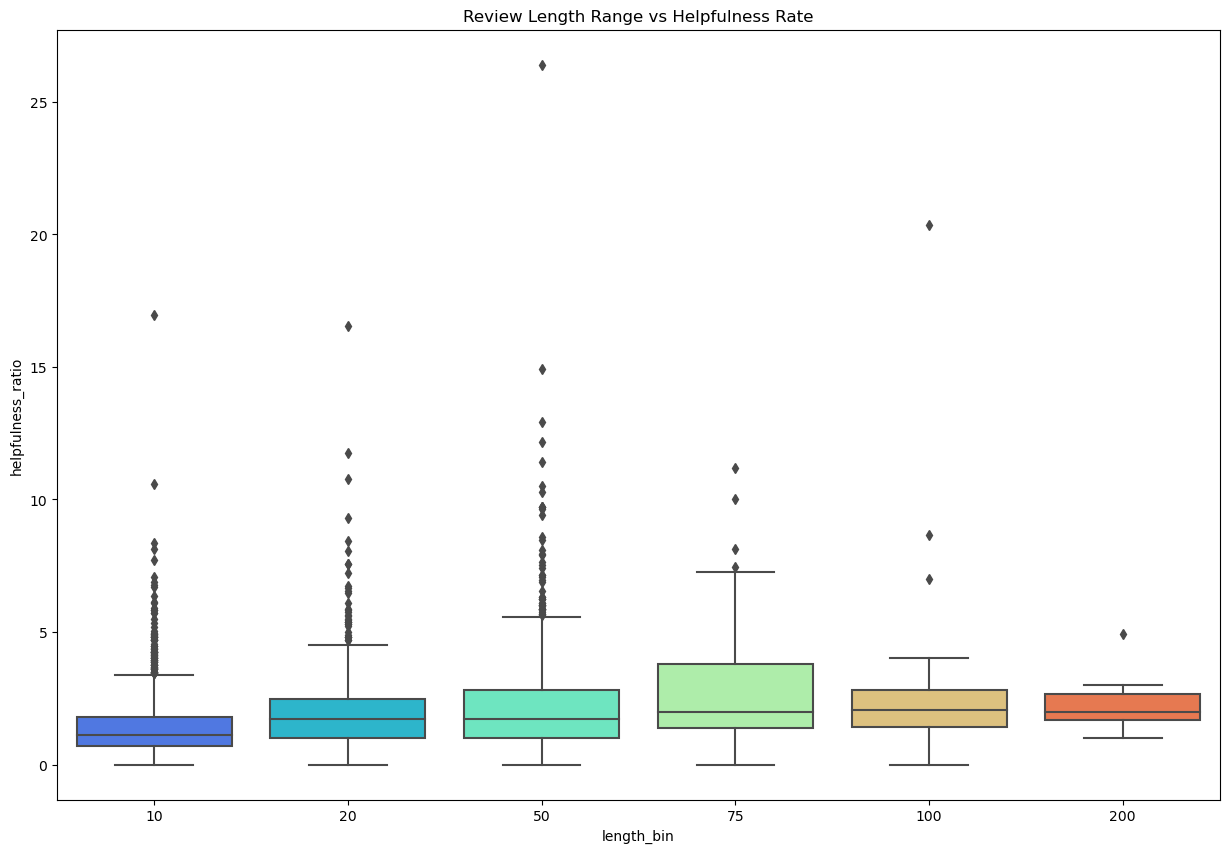

In [8]:
df_camp = words_df.sample(withReplacement=False,
                          fraction=3000/words_df.count(), seed=42)

words_df_pd = df_camp.toPandas()

# scatter plot of count vs helpfulness ratio
plt.scatter(words_df_pd['count'], words_df_pd['helpfulness_ratio'], alpha=0.2)
plt.xlabel('Number of positive words')
plt.ylabel('Helpful score')
plt.show()

groups = [0, 10, 20, 50, 75, 100, 200]
words_df_pd['length_bin'] = pd.cut(words_df_pd['count'], bins=groups, labels=[
                                   group for group in groups[1:]])

# Plot the distribution of positive_words with respect to helpfulness rate
plt.figure(figsize=(15, 10))
sns.boxplot(x='length_bin', y='helpfulness_ratio',
            data=words_df_pd, palette='rainbow')

plt.title('Review Length Range vs Helpfulness Rate')

In [9]:
spark.stop()